First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-01-26 01:31:28.272306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 01:31:28.274637: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 01:31:28.278128: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 01:31:28.287871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737873088.304219 2469876 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737873088.30

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

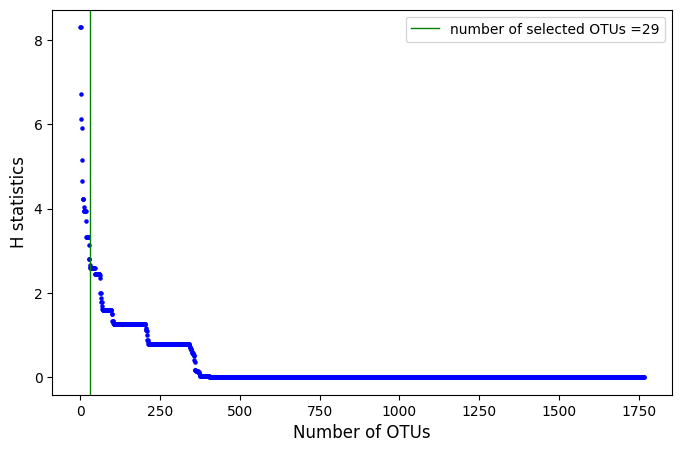

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,un_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [8]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [9]:

targetLabel=un_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list

X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)

X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)

X_FS_lasso,xlabel_FS_lasso0 = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
xlabel_FS_lasso = selectedOTU_index_list[xlabel_FS_lasso0]
X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
xlabel_FS_lasso_ft = selectedOTU_index_list[xlabel_FS_lasso_ft0]

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lasso":X_FS_lasso,
               "FS_Lassofinetune":X_FS_lasso_ft,
               #"Random":data
              }


The response variable and its counts are:
UN
Urban      33
Natural    26
Name: count, dtype: int64
Best alpha: 0.1
Best alpha: 0.05


In [10]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))

The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 29)
The shape of the Lasso selected dataset is  (59, 58)
The shape of the Lasso_finetune selected dataset is  (59, 11)
The shape of the FS_Lasso selected dataset is  (59, 14)
The shape of the FS_Lasso_finetune selected dataset is  (59, 14)


In [11]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=cls,SMOTE=True)

Classes: ['Natural' 'Urban']
[0.7777777777777778, 0.6571428571428571, 0.8571428571428571, 0.7714285714285715, 0.44999999999999996]
[0.3888888888888889, 0.5142857142857142, 0.657142857142857, 0.22857142857142854, 0.3333333333333333]
[0.5555555555555556, 0.4857142857142857, 0.7714285714285715, 0.6, 0.5]
[0.5416666666666667, 0.48571428571428565, 0.5857142857142857, 0.7285714285714286, 0.6833333333333333]
[0.7777777777777778, 0.4714285714285714, 0.6857142857142857, 0.657142857142857, 0.7]
[0.2222222222222222, 0.44285714285714284, 0.11428571428571428, 0.6285714285714286, 0.6]
[0.8055555555555556, 0.3, 0.7714285714285714, 0.4571428571428571, 0.7333333333333333]
[0.8611111111111112, 0.6428571428571429, 0.8857142857142857, 0.7714285714285714, 0.8666666666666667]
[0.8333333333333334, 0.8285714285714285, 0.9, 0.8428571428571429, 0.8166666666666667]
[1.0, 0.9142857142857143, 0.8571428571428572, 0.8285714285714285, 0.5666666666666667]
[0.9444444444444444, 0.8142857142857143, 0.9428571428571428, 0.

In [12]:
print(metric.metric_sum(dict_cm))

                           Accuracy  Precision   Recall   Specification  \
AllFeatures_RF             0.559322  0.500000   0.230769    0.818182      
AllFeatures_SVM            0.559322  0.500000   0.346154    0.727273      
AllFeatures_CatBoost       0.525424  0.400000   0.153846    0.818182      
AllFeatures_NB             0.610169  0.551724   0.615385    0.606061      
SelectMicro_RF             0.627119  0.590909   0.500000    0.727273      
SelectMicro_SVM            0.610169  0.555556   0.576923    0.636364      
SelectMicro_CatBoost       0.593220  0.550000   0.423077    0.727273      
SelectMicro_NB             0.644068  0.558140   0.923077    0.424242      
Lasso_RF                   0.661017  0.875000   0.269231    0.969697      
Lasso_SVM                  0.677966  0.684211   0.500000    0.818182      
Lasso_CatBoost             0.694915  0.900000   0.346154    0.969697      
Lasso_NB                   0.864407  0.950000   0.730769    0.969697      
Lasso_finetune_RF        

In [13]:
dict_cm2 = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=['xgboost'],SMOTE=True)

Classes: ['Natural' 'Urban']
[0.3333333333333333, 0.6142857142857143, 0.6857142857142857, 0.5, 0.3]
[0.6944444444444445, 0.4285714285714286, 0.7, 0.6428571428571428, 0.55]
[0.6666666666666667, 0.5285714285714286, 0.8285714285714285, 0.6285714285714286, 0.5333333333333333]
[0.5833333333333333, 0.5857142857142857, 0.7428571428571429, 0.8, 0.6]
[0.5138888888888888, 0.9142857142857143, 0.657142857142857, 0.5, 0.75]
[0.5138888888888888, 0.9142857142857143, 0.657142857142857, 0.5, 0.75]
                  xgboost_Accuracy  xgboost_AUC  xgboost_Accuracy_std  \
AllFeatures           0.521212       0.486667          0.154174         
SelectMicro           0.540909       0.603175          0.106017         
Lasso                 0.677273       0.637143          0.098962         
Lasso_finetune        0.659091       0.662381          0.112264         
FS_Lasso              0.662121       0.667063          0.155965         
FS_Lassofinetune      0.662121       0.667063          0.155965         

  

## compare the first 20 index

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=selectedOTU_index_list[:entries]
selectedASVs20_list = selectedASV_list[:entries]

Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
     OTU    presence_pos  presence_neg
0    ASV72    0.230769      0.000000  
1   ASV111    0.230769      0.000000  
2    ASV26    0.269231      0.030303  
3    ASV79    0.000000      0.212121  
4    ASV18    0.307692      0.060606  
5    ASV73    0.000000      0.181818  
6    ASV39    0.269231      0.060606  
7    ASV52    0.000000      0.151515  
8    ASV81    0.000000      0.151515  
9   ASV148    0.000000      0.151515  
10   ASV95    0.192308      0.030303  
11   ASV37    0.115385      0.000000  
12   ASV70    0.115385      0.000000  
13   ASV99    0.115385      0.000000  
14  ASV129    0.115385      0.000000  
15  ASV138    0.115385      0.000000  
16  ASV179    0.115385      0.000000  
17  ASV180    0.115385      0.000000  
18   ASV38    0.038462      0.212121  
19  ASV104    0.000000      0.121212  


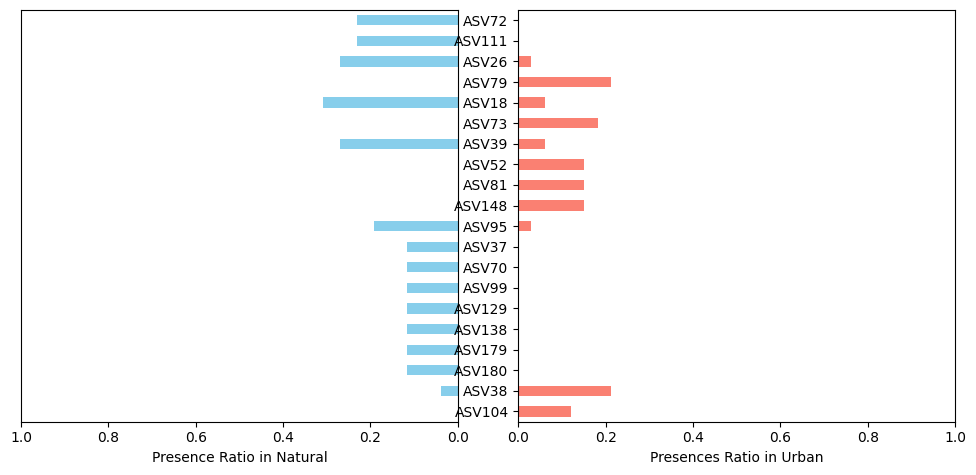

Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
     OTU    presence_pos  presence_neg
0    ASV18    0.307692      0.060606  
1    ASV52    0.000000      0.151515  
2    ASV76    0.115385      0.060606  
3    ASV79    0.000000      0.212121  
4    ASV81    0.000000      0.151515  
5    ASV95    0.192308      0.030303  
6   ASV111    0.230769      0.000000  
7   ASV114    0.000000      0.121212  
8   ASV138    0.115385      0.000000  
9   ASV179    0.115385      0.000000  
10  ASV225    0.076923      0.000000  


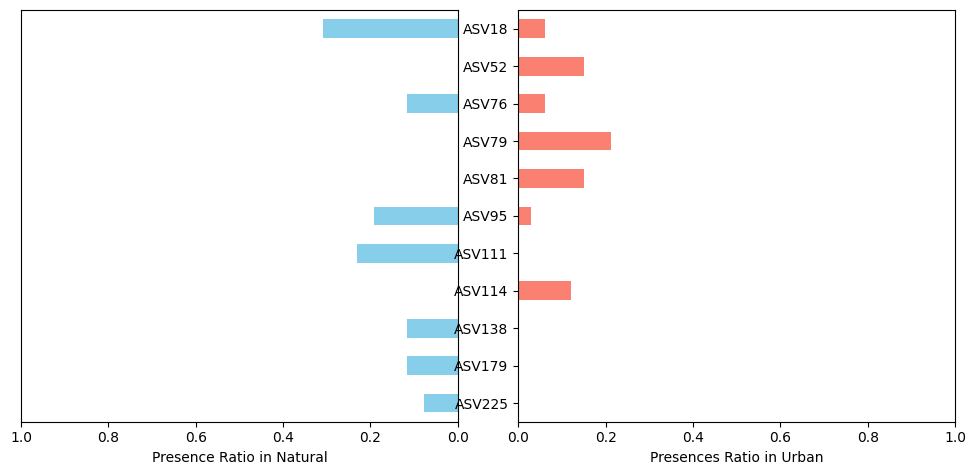

Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
     OTU    presence_pos  presence_neg
0   ASV111    0.230769      0.000000  
1    ASV79    0.000000      0.212121  
2    ASV52    0.000000      0.151515  
3    ASV81    0.000000      0.151515  
4    ASV95    0.192308      0.030303  
5    ASV70    0.115385      0.000000  
6    ASV99    0.115385      0.000000  
7   ASV138    0.115385      0.000000  
8   ASV179    0.115385      0.000000  
9   ASV180    0.115385      0.000000  
10  ASV104    0.000000      0.121212  
11  ASV110    0.000000      0.121212  
12  ASV114    0.000000      0.121212  
13   ASV15    0.230769      0.060606  


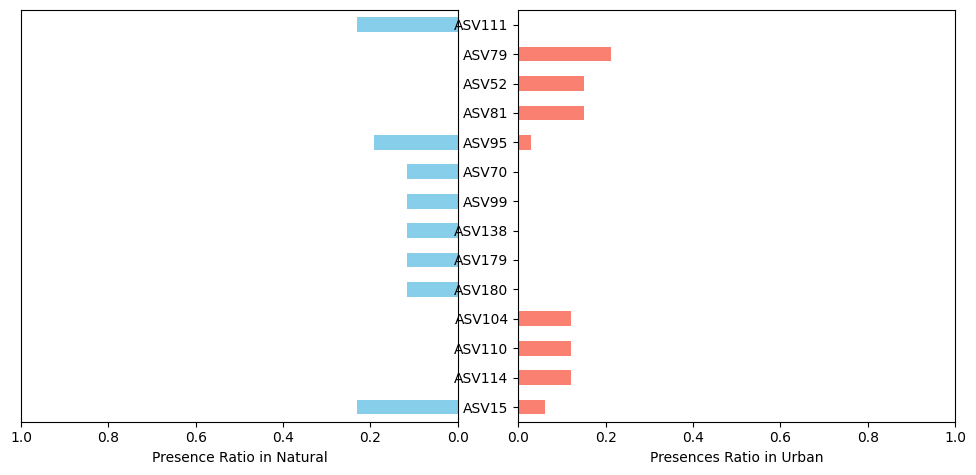

In [17]:
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list],targetLabel,selectedASVs20_list,
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_lasso_ft,targetLabel,ASVs[xlabel_lasso_ft],
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_FS_lasso_ft,targetLabel,ASVs[xlabel_FS_lasso_ft],
                     posLabel="Natural",posText="Natural",negText="Urban")